# CNN-Based Peak Fitting in Synthetic XRD-CT Datasets

## 📝 Introduction

In this notebook, we investigate a new **self-supervised deep learning approach** for peak fitting in synthetic XRD-CT datasets, and compare it to a conventional parameter-based fitting workflow. Both approaches are applied to a phantom dataset generated using the `nDTomo` package, simulating realistic peak shapes and background contributions under Poisson noise.

Peak fitting remains a critical step in XRD-CT analysis, enabling the extraction of quantitative parameters such as phase content, strain, and crystallite size. However, traditional voxel-by-voxel fitting methods can be slow, sensitive to noise, and difficult to scale. Here, we test whether a CNN trained directly on downsampled spectra can learn to infer accurate and denoised peak parameter maps.

## 🎯 Objectives

By the end of this notebook, you will:
- Generate a synthetic 3D XRD-CT dataset with spatially varying Gaussian peaks and linear background
- Add realistic Poisson noise to simulate photon-limited experiments
- Fit the data using two approaches:
  - Conventional parameter map-based fitting
  - **PeakFitCNN**: a self-supervised CNN that infers peak parameters from downsampled input
- Evaluate and compare the accuracy and noise robustness of both methods

## 🤖 What is PeakFitCNN?

PeakFitCNN is a **self-supervised convolutional neural network** designed to learn peak parameters from hyperspectral XRD-CT data **without needing ground truth labels**. It works by:
- Receiving a 4× downsampled hyperspectral input volume
- Predicting full-resolution parameter maps (amplitude, position, width, background slope and intercept)
- Reconstructing the spectra using a differentiable peak model
- Optimizing only through the reconstruction error

This approach naturally combines **denoising**, **super-resolution**, and **peak decomposition**, while avoiding the instability of pixel-wise nonlinear curve fitting.

## 📦 Dataset

We will use a synthetic dataset constructed as follows:
- Each voxel contains a **single Gaussian peak** with a linear background
- The five peak parameters vary smoothly across the field of view
- The diffraction axis is sampled over:

$$
(x, y, q) = (240, 240, 50)
$$

where $q$ represents the diffraction domain (e.g., $2\theta$).

Poisson noise is added to approximate photon-counting uncertainty, mimicking experimental conditions.

We now begin by importing the required modules and generating the simulated dataset.

## 🏗️ Generate Synthetic Spatial Maps

We begin by generating five synthetic 2D spatial images using the `nDTomophantom_2D()` function. Each image (`im1` to `im5`) will later be used to define a different peak or background parameter (e.g., peak position, width, amplitude, background slope/intercept) across the field of view.

These phantoms serve as parameter maps with smoothly varying features, simulating different chemical or structural domains in a realistic XRD-CT sample.

We also normalize `im5` so that it scales between 0 and 1, which is useful for defining background offset values. Finally, the spatial maps are visualized using `showim()` to verify the underlying structures.

c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorith

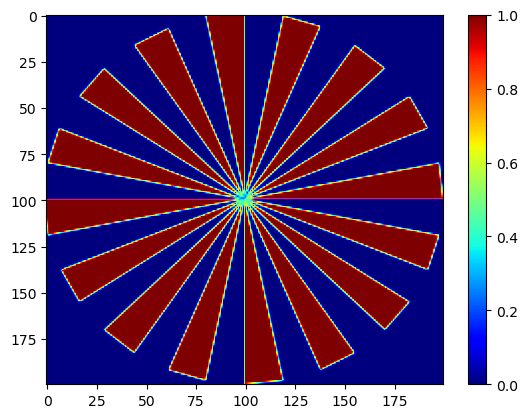

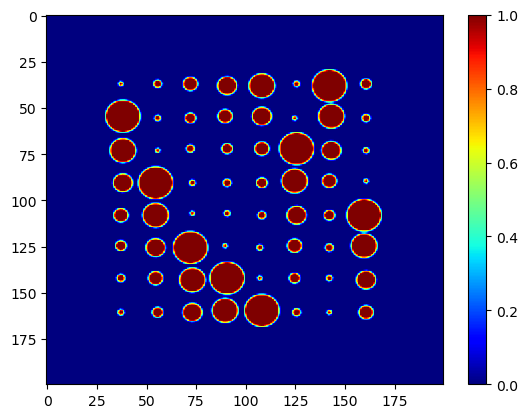

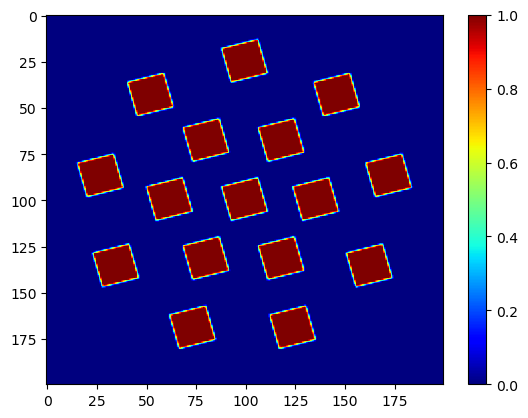

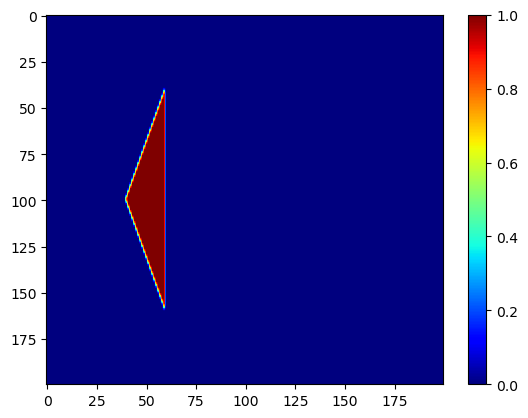

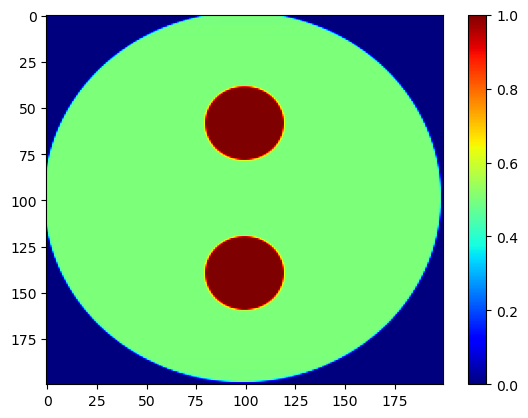

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim


# Create 2D spatial images for the five components
npix = 200
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)


## 🧪 Simulate Hyperspectral Volume with Spatially Varying Peak Parameters

We now define the **analytical peak model** used to generate our synthetic dataset. Each voxel in the volume will contain a spectrum consisting of a **single Gaussian peak** with a **linear background**.

Two functions are defined:
- `gaussian(x, A, mu, sigma)` – generates a peak given amplitude, center, and width
- `linear_background(x, slope, intercept)` – models a linear baseline across the diffraction axis

We then:
1. Define the diffraction axis `x`, sampled between 0 and 5 with a step size of 0.1
2. Specify the valid parameter ranges for all five quantities:
   - **Peak amplitude** (A): varies with `im2 + im5`
   - **Peak position** (μ): varies with `im2`
   - **Peak width** (σ): varies with `im3`
   - **Background slope**: varies with `im4`
   - **Background intercept**: varies with `im5`

The resulting 2D hyperspectral image `vol` is populated voxel-by-voxel, only in regions with non-negligible peak amplitude (`mask_tmp > 0`).

We then pad the hyperspectral image spatially by 20 pixels on each side to ensure compatibility with CNN architectures that may expect padding or stride-sensitive dimensions.

Finally, we simulate **Poisson noise** using the `addpnoise3D()` function, which mimics photon-counting statistics typically observed in synchrotron X-ray imaging. The noise level is controlled by a `ct` value (e.g. 100 = moderate photon count). The resulting noisy synthetic dataset will be used for both conventional and CNN-based fitting.

In [2]:

def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
# x = np.arange(0, 5, 0.025)
# x = np.arange(0, 5, 0.075)
x = np.arange(0, 5, 0.1)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 20
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))


def addpnoise3D(vol, ct):
    '''
    Adds Poisson noise to a 3D hyperspectral volume (H x W x Bands),
    noise is added per pixel-spectrum (i.e., per (i,j,:)).
    
    Parameters
    ----------
    vol : ndarray
        3D hyperspectral image (H x W x Bands), must be non-negative.
    ct : float
        Scaling constant to simulate photon counts.
    '''
    vol = vol.copy()
    mi = np.min(vol)
    if mi < 0:
        vol = vol - mi + np.finfo(np.float32).eps
    elif mi == 0:
        vol = vol + np.finfo(np.float32).eps

    # Apply Poisson noise per pixel-spectrum
    noisy = np.random.poisson(vol * ct) / ct
    return noisy

# vol = vol + 0.001*np.random.rand(vol.shape[0], vol.shape[1], vol.shape[2])
# # vol = addpnoise3D(vol, ct=1000)
vol = addpnoise3D(vol, ct=100)
vol[vol<0] = 0



100%|██████████| 200/200 [00:00<00:00, 549.71it/s]


(240, 240, 50) 1.5


We can now interactively explore the spectral content of this volume using the chemimexplorer

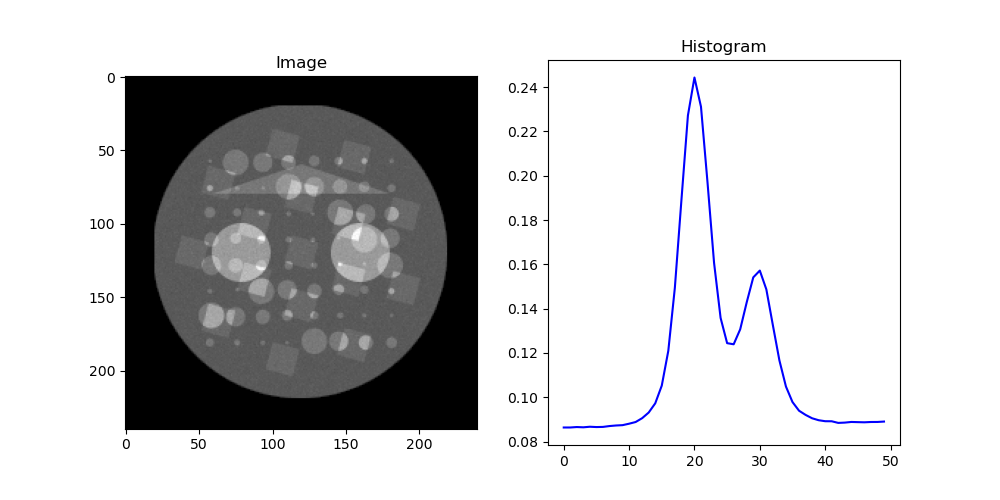

In [3]:
from nDTomo.methods.hyperexpl import chemimexplorer
                
%matplotlib widget
    
# Create an instance of the GUI
gui = chemimexplorer(vol)

## 🎯 Patch Sampling Strategy for CNN Training

To train the PeakFitCNN model efficiently, we operate on smaller image patches rather than the full hyperspectral volume. This section defines a **patch-based sampling strategy** that allows randomized, GPU-efficient access to valid (non-zero) regions of the volume.

Key steps include:

1. **Patch and sampling parameters**:
   - `patch_size = 32`: the spatial size of each square patch
   - `num_patches = 16`: number of patches drawn per iteration (i.e., batch size)
   - `num_iterations = 100`: total training steps per epoch

2. **Valid mask generation**:
   - A binary mask is computed from the sum over spectral channels to identify meaningful (non-zero) regions.
   - Padding is added to the volume and mask to ensure valid patch extraction near image borders.

3. **Sampling diagnostics**:
   - We estimate the **percentage of pixels probed per epoch**, based on patch size and number.
   - We compute the **number of iterations required** to probe the entire image once.

4. **Patch index selection**:
   - Valid patch indices are extracted using `filter_patch_indices()` to avoid sampling background-only regions.
   - These indices are used to initialize a patch-based coverage `counter` which tracks how often each pixel is sampled.

5. **Visualization**:
   - We visualize both the binary mask and the patch coverage map, helping verify that the sampling scheme is balanced and covers all important regions.

This patch sampling setup enables training with limited memory while ensuring statistical coverage of the whole sample over multiple iterations.

(304, 304, 50) (240, 240, 50) (304, 304)


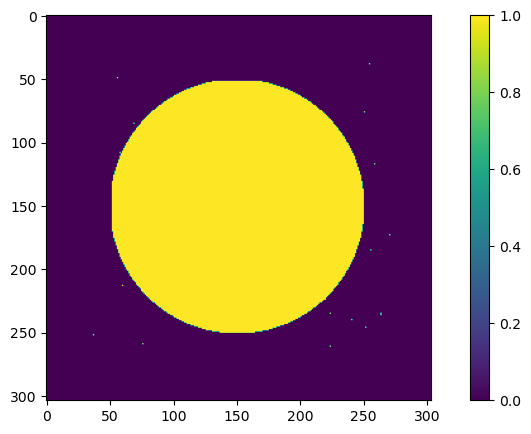

Percentage of pixels probed during one epoch: 51.64218621950451
Number of iterations required to probe full image: 2
The number of patches is  52
The number of iterations (batches) required to probe the whole image is  3
tensor(1.)


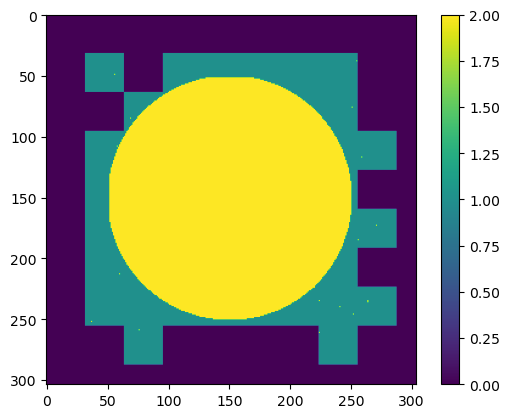

In [4]:
import torch, time
import torch.nn.functional as F
from torch import nn
from nDTomo.pytorch.utils_torch import calc_patches_indices, denormalize, filter_patch_indices, update_counter, initialize_counter, calc_patches_indices

%matplotlib inline

num_iterations = 100
distribution_type = 'uniform'
std_dev = int(vol.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16

mask = np.copy(np.sum(vol,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(vol)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, vol.shape, mask.shape)

plt.figure(1);plt.clf()
plt.imshow(mask)
plt.colorbar()
plt.show()

npix = np.sum(mask)
pcr_probed = 100* (patch_size*patch_size*num_patches)/npix
print(f"Percentage of pixels probed during one epoch: {pcr_probed}")
niters_required = int(np.ceil(100/pcr_probed))
print(f"Number of iterations required to probe full image: {niters_required}")

mask_t = torch.tensor(mask, dtype=torch.bool, device=device)

indices = filter_patch_indices(torch.tensor(mask), patch_size)
print('The number of patches is ', len(indices))
print('The number of iterations (batches) required to probe the whole image is ', int(len(indices)/num_patches) )

counter = initialize_counter(rows, cols)
patch_dimensions = (patch_size, patch_size)
update_counter(counter, indices, patch_dimensions)
print(counter.max())
counter = counter.numpy()

plt.figure(2);plt.clf()
plt.imshow(counter + mask)
plt.colorbar()
plt.show()

## 🧠 Define PeakFitCNN Architecture and Initial Parameter Model

This section defines the neural network components used in the PeakFitCNN pipeline.

### 📐 `PeakFitCNN` Class

The `PeakFitCNN` class implements a **self-supervised upsampling CNN** that takes a spatially downsampled hyperspectral input (e.g., 4× smaller) and predicts full-resolution maps of peak parameters. It supports configurable normalization (instance, batch, or layer norm), bilinear upsampling, and optional final activation (e.g., ReLU or Sigmoid).

- The input is typically the downscaled hyperspectral imaging data or a low-resolution estimate or feature map.
- The output is a stack of parameter maps (e.g., amplitude, center, width, background).
- The network upsamples via two stages (2× + 2× for a total 4×).

### 🧩 `PrmCNN2D` Class

The `PrmCNN2D` class provides a modular structure for representing the initial parameter maps:
- If `prms_layer=True`, it holds a set of **trainable parameter tensors**, e.g. initialized to zeros or random values.
- If `cnn_layer=True`, a CNN is applied to either:
  - the initialized parameters, or
  - a provided input volume.

This module can operate in **three modes**:
1. Parameter map only (`prms_layer=True`, `cnn_layer=False`) — conventional approach.
2. CNN only (`prms_layer=False`, `cnn_layer=True`) — fully learned from input.
3. Combined (`prms_layer=True`, `cnn_layer=True`) — trainable initial maps refined via CNN layers.

---

### 🔢 Configuration and Parameter Count

We define:
- A single Gaussian peak per spectrum (`num_peaks = 1`)
- 3 peak parameters (area, position, width)
- 2 background parameters (slope, intercept)
- `total_params = 5`

We instantiate the `PrmCNN2D` model in **parameter-map-only mode**, initialized to zero. This setup corresponds to the **conventional voxel-wise fitting approach**, where each parameter is independently stored as a learnable 2D map.

The total number of trainable parameters is printed for comparison with the full resolution grid size.

In [5]:

class PeakFitCNN(nn.Module):
    
    def __init__(self, nch_in=1, nch_out=1, nfilts=32, upscale_factor = 4,
                 norm_type='instance', activation='Linear', padding='same', npix=None):
        super(PeakFitCNN, self).__init__()

        self.npix = npix
        self.upscale_factor = upscale_factor
        # Initial feature extraction
        self.input = nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding, bias=True)

        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
        layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
        # Add normalization based on norm_type
        if norm_type == "instance":
            layers.append(nn.InstanceNorm2d(nfilts, affine=True))
        elif norm_type == "batch":
            layers.append(nn.BatchNorm2d(nfilts))
        elif norm_type == "layer":
            layers.append(nn.LayerNorm([nfilts, 2*self.npix, 2*self.npix]))

        # Add activation function
        layers.append(nn.ReLU(inplace=True))

        self.upsample1 = nn.Sequential(*layers)

        if self.upscale_factor == 4:
            layers = []
            layers.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False))
            layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding, bias=True))
            # Add normalization based on norm_type
            if norm_type == "instance":
                layers.append(nn.InstanceNorm2d(nfilts, affine=True))
            elif norm_type == "batch":
                layers.append(nn.BatchNorm2d(nfilts))
            elif norm_type == "layer":
                layers.append(nn.LayerNorm([nfilts, 4*self.npix, 4*self.npix]))
            # Add activation function
            layers.append(nn.ReLU(inplace=True))

            self.upsample2 = nn.Sequential(*layers)

        # Final output layer
        self.xrdct = nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding, bias=True)

        # Final activation
        self.final_activation = None
        if activation == "ReLU":
            self.final_activation = nn.ReLU()
        elif activation == "Sigmoid":
            self.final_activation = nn.Sigmoid()
        elif activation == "LeakyReLU":
            self.final_activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):  # Feature maps from autoencoder2D are passed

        x = self.input(x)

        # Upsampling 1
        x = self.upsample1(x)

        if self.upscale_factor == 4:
            # Upsampling 2
            x = self.upsample2(x)

        # Output layer
        x = self.xrdct(x)

        if self.final_activation is not None:
            x = self.final_activation(x)

        return x
    
class PrmCNN2D(nn.Module):
    def __init__(self, npix, nch_in=1, nch_out=1, nfilts=32, nlayers=4, norm_type='layer', 
                 prms_layer=True, cnn_layer=True, tensor_vals = 'random', tensor_initial = None,
                 padding='same'):
        super(PrmCNN2D, self).__init__()
        self.npix = npix
        self.prms_layer = prms_layer
        self.cnn_layer = cnn_layer

        if self.prms_layer:
            if tensor_vals == 'random':
                self.initial_tensor = nn.Parameter(2*torch.randn(1, nch_in, npix, npix)-1)
            elif tensor_vals == 'zeros':
                self.initial_tensor = nn.Parameter(torch.zeros(1, nch_in, npix, npix))
            elif tensor_vals == 'ones':
                self.initial_tensor = nn.Parameter(torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'mean':
                self.initial_tensor = nn.Parameter(0.5*torch.ones(1, nch_in, npix, npix))
            elif tensor_vals == 'random_positive':
                self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
            elif tensor_vals == 'custom':
                try:
                    self.initial_tensor = nn.Parameter(tensor_initial)
                except:
                    print('Custom tensor not provided. Using random tensor instead')
                    self.initial_tensor = nn.Parameter(torch.randn(1, nch_in, npix, npix))
        if self.cnn_layer:
            layers = []
            layers.append(nn.Conv2d(nch_in, nfilts, kernel_size=3, stride=1, padding=padding))  # 'same' padding in PyTorch is usually done by manually specifying the padding
            if norm_type=='layer':
                if padding=='valid':
                    layers.append(nn.LayerNorm([nfilts, self.npix -2, self.npix -2]))
                else:
                    layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
            elif norm_type=='instance':
                layers.append(nn.InstanceNorm2d(nfilts, affine = True))
            elif norm_type=='batchnorm':            
                layers.append(nn.BatchNorm2d(nfilts))

            layers.append(nn.ReLU())

            for layer in range(nlayers):
                
                layers.append(nn.Conv2d(nfilts, nfilts, kernel_size=3, stride=1, padding=padding))
                if norm_type=='layer':
                    if padding=='valid':
                        layers.append(nn.LayerNorm([nfilts, self.npix -2*(layer + 2), self.npix -2*(layer + 2)]))
                    else:
                        layers.append(nn.LayerNorm([nfilts, self.npix, self.npix]))
                elif norm_type=='instance':
                    layers.append(nn.InstanceNorm2d(nfilts, affine = True))            
                elif norm_type=='batchnorm':            
                    layers.append(nn.BatchNorm2d(nfilts))

                layers.append(nn.ReLU())

            layers.append(nn.Conv2d(nfilts, nch_out, kernel_size=3, stride=1, padding=padding))
            layers.append(nn.Sigmoid())
            self.cnn2d = nn.Sequential(*layers)

    def forward(self, x):
        if self.prms_layer and self.cnn_layer:
            out = self.cnn2d(torch.sigmoid(self.initial_tensor))
        elif self.cnn_layer and not self.prms_layer:
            out = self.cnn2d(x)
        elif self.prms_layer and not self.cnn_layer:
            out = torch.sigmoid(self.initial_tensor)
        return out
    

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None', prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)


Total number of parameters: 462080
Conventional number of parameters: 462080


## 🧪 Train PeakFitCNN in a Self-Supervised Manner

We now train the `PeakFitCNN` model using a **self-supervised learning strategy** based on physical reconstruction of the spectra. The CNN is optimized to predict normalized peak parameter maps, from which we reconstruct the full hyperspectral volume and compare it directly to the observed data (`volp`).

### 🧱 Model Components

- **Gaussian model**: The `gaussian()` function defines the parametric form of the peak used for spectral reconstruction.
- **Normalization bounds**: We define `param_min` and `param_max` dictionaries that set the physical limits for each parameter type (Area, Position, FWHM, Slope, Intercept). These are used to scale network outputs to valid physical ranges.
- **Loss function**: Mean Absolute Error (L1 loss) is used as the reconstruction loss. Additional metrics (MSE, RMSE) are also tracked for monitoring.
- **Input image**: We create a single-channel static image from the sum of all spectral channels, normalized and reshaped appropriately for the CNN input.

### 🔁 Training Loop

The model is trained over multiple epochs using the following loop:
1. The CNN produces a set of normalized parameter maps (`yc`) from the static image input.
2. These maps are locally filtered and then **clamped** using a ±20% soft constraint (`prf`) to stabilize training.
3. Parameters are denormalized and used to reconstruct each spectrum voxel-by-voxel:
   - Gaussian peaks are added for each voxel using predicted amplitude, position, and width.
   - Linear background is then added using predicted slope and intercept.
4. The reconstructed spectra are compared to the ground truth data (`volp`) for randomly sampled patches.
5. Loss is computed using RMSE and gradients are backpropagated to update model parameters.

A learning rate scheduler reduces the step size upon plateauing, and early stopping is triggered if the minimum learning rate is reached.

### 🕒 Training Time & Convergence

This block tracks:
- Total training time
- Number of epochs until convergence
- Final MAE, MSE, RMSE
- A loss log (`logloss`) for plotting learning curves later

This setup enables **self-supervised training of peak parameters** without any labelled supervision — the only objective is to minimize the difference between the observed and reconstructed spectra.

In [6]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()


### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

with torch.no_grad():
    yprms = model(im_static)
    yprms = F.interpolate(yprms, scale_factor=1/4, mode='bilinear', align_corners=False)


epochs = 50000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model(im_static)
        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)

        lower_bound = filtered * (1 - prf)
        upper_bound = filtered * (1 + prf)

        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)
        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)   
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

4


  0%|          | 2/50000 [00:00<48:37, 17.14it/s]

MAE =  tensor(0.4788, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3374, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5809, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6152867


  0%|          | 55/50000 [00:01<29:05, 28.61it/s]

MAE =  tensor(0.0335, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0429, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03894387


  0%|          | 106/50000 [00:03<28:54, 28.77it/s]

MAE =  tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036006674


  0%|          | 155/50000 [00:05<29:01, 28.63it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0403, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035416365


  0%|          | 207/50000 [00:07<27:39, 30.00it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0402, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03520732


  1%|          | 254/50000 [00:08<28:23, 29.20it/s]

MAE =  tensor(0.0290, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035062805


  1%|          | 304/50000 [00:10<27:40, 29.93it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035021193


  1%|          | 356/50000 [00:12<29:10, 28.37it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03497885


  1%|          | 403/50000 [00:13<29:16, 28.24it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0349601


  1%|          | 455/50000 [00:15<29:04, 28.39it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0349316


  1%|          | 503/50000 [00:17<29:21, 28.10it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03494472


  1%|          | 554/50000 [00:19<27:52, 29.57it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034921594


  1%|          | 606/50000 [00:20<28:47, 28.59it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03491112


  1%|▏         | 655/50000 [00:22<27:49, 29.56it/s]

MAE =  tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03488415


  1%|▏         | 707/50000 [00:24<28:14, 29.08it/s]

MAE =  tensor(0.0282, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03488827


  2%|▏         | 755/50000 [00:26<28:15, 29.05it/s]

MAE =  tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034878854


  2%|▏         | 806/50000 [00:27<27:58, 29.31it/s]

MAE =  tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034864113


  2%|▏         | 853/50000 [00:29<27:56, 29.32it/s]

MAE =  tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0399, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034862168


  2%|▏         | 906/50000 [00:31<27:01, 30.28it/s]

MAE =  tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0400, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034871895


  2%|▏         | 955/50000 [00:32<28:41, 28.49it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034381047


  2%|▏         | 1006/50000 [00:34<29:38, 27.54it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03437399


  2%|▏         | 1054/50000 [00:36<27:56, 29.20it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034371335


  2%|▏         | 1106/50000 [00:38<28:13, 28.87it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034369748


  2%|▏         | 1156/50000 [00:39<28:42, 28.35it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034368787


  2%|▏         | 1205/50000 [00:41<32:59, 24.65it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034363844


  3%|▎         | 1254/50000 [00:43<28:55, 28.09it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03436304


  3%|▎         | 1306/50000 [00:45<28:01, 28.96it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034360997


  3%|▎         | 1357/50000 [00:47<26:31, 30.56it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0343605


  3%|▎         | 1406/50000 [00:48<28:24, 28.51it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034360167


  3%|▎         | 1456/50000 [00:50<28:17, 28.59it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034359038


  3%|▎         | 1506/50000 [00:52<27:48, 29.06it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034358807


  3%|▎         | 1555/50000 [00:53<27:44, 29.11it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034358256


  3%|▎         | 1604/50000 [00:55<27:30, 29.33it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0343581


  3%|▎         | 1656/50000 [00:57<28:56, 27.84it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357816


  3%|▎         | 1706/50000 [00:59<28:28, 28.27it/s]

MAE =  tensor(0.0277, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03435773


  4%|▎         | 1755/50000 [01:00<28:50, 27.88it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357578


  4%|▎         | 1807/50000 [01:02<27:35, 29.11it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357525


  4%|▎         | 1856/50000 [01:04<27:38, 29.02it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357443


  4%|▍         | 1906/50000 [01:06<28:28, 28.15it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357414


  4%|▍         | 1956/50000 [01:07<27:48, 28.79it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03435737


  4%|▍         | 2004/50000 [01:09<27:50, 28.74it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357354


  4%|▍         | 2056/50000 [01:11<26:41, 29.94it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357328


  4%|▍         | 2105/50000 [01:13<27:06, 29.44it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357317


  4%|▍         | 2153/50000 [01:14<27:33, 28.94it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357302


  4%|▍         | 2206/50000 [01:16<26:43, 29.80it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357302


  5%|▍         | 2256/50000 [01:18<29:35, 26.89it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03435729


  5%|▍         | 2306/50000 [01:20<30:34, 26.00it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357287


  5%|▍         | 2353/50000 [01:21<28:20, 28.02it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357287


  5%|▍         | 2405/50000 [01:23<27:18, 29.05it/s]

MAE =  tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.034357283


  5%|▍         | 2446/50000 [01:25<27:32, 28.77it/s]

Minimum learning rate reached, stopping the optimization
2446
2446 tensor(0.0276, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>) 0.03435728
85.01495003700256


## 📊 Visualize Training Loss and CNN-Predicted Parameter Maps

In this final section, we evaluate the performance of the trained PeakFitCNN model by visualizing both the training history and the reconstructed peak parameter maps.

### 📉 Loss Curve

We first plot the logged RMSE loss (`logloss`) across training epochs (starting from epoch 100 for clarity). This helps verify whether the model has converged and how stable the optimization process was.

### 🗺️ Extract Predicted Parameters from CNN

After training, we extract the output from the model:
- The raw predicted maps are optionally smoothed using a `3×3` average filter.
- Each parameter map (area, position, FWHM, slope, intercept) is **denormalized** to recover physical units.
- The output maps are spatially cropped to remove padding (based on the difference in shape between predicted and ground truth volumes).

### 🎯 Masked Comparison and Visual Output

To compare the CNN results with the ground truth:
- A mask is applied to focus only on the regions where meaningful signal exists (i.e., where `peak_area > 0.1`).
- The CNN-predicted maps are **concatenated side-by-side** with the corresponding ground truth maps for visual inspection.

This comparison is done for all five parameters:
1. **Peak Area**
2. **Peak Position**
3. **Peak FWHM**
4. **Background Slope**
5. **Background Intercept**

Each parameter is shown as a 2D image, where the **left half** corresponds to the ground truth and the **right half** shows the PeakFitCNN prediction (masked to remove background).

These visualizations help assess both spatial fidelity and denoising performance of the CNN-based peak fitting approach.

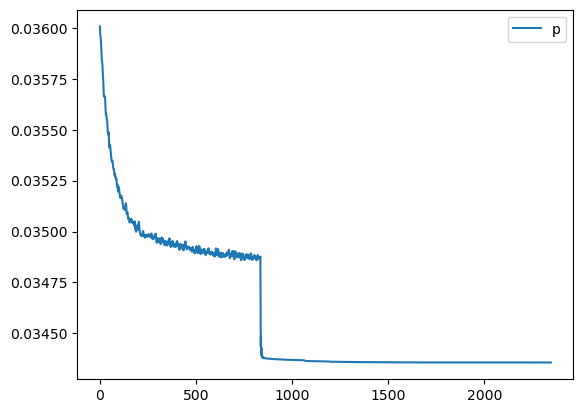

(304, 304) (304, 304) (304, 304) (304, 304) (304, 304)
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)
52
(200, 200) (200, 200) (200, 200) (200, 200) (200, 200)


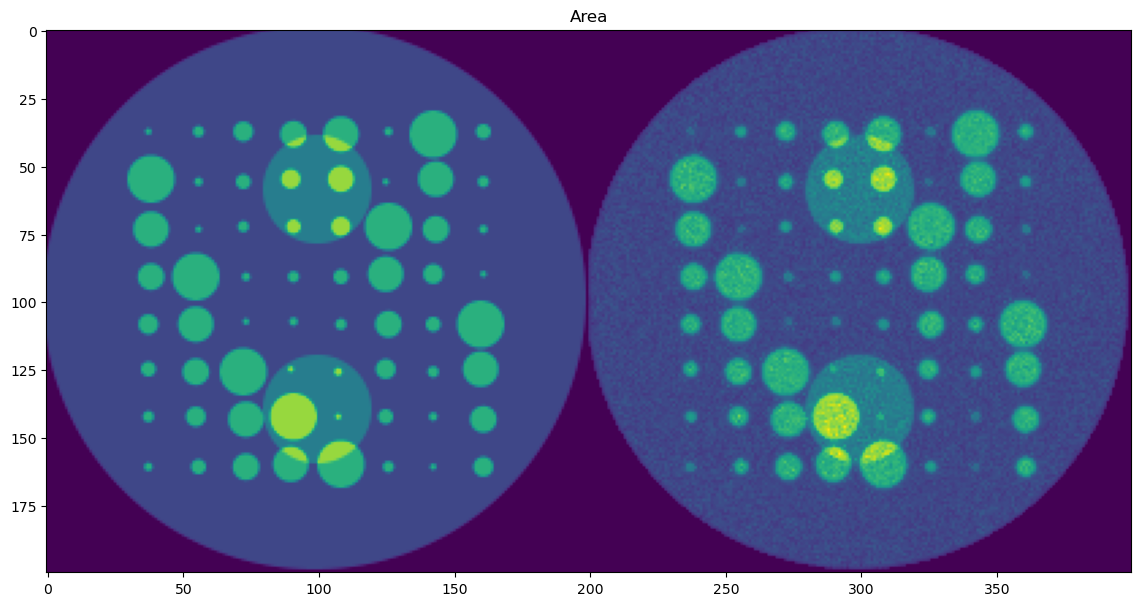

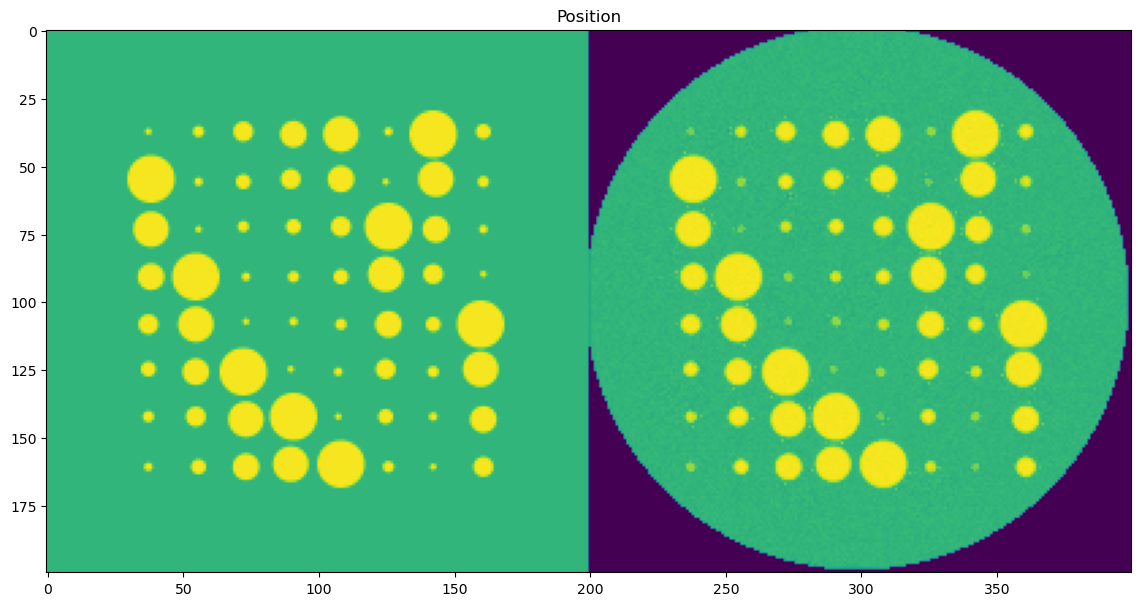

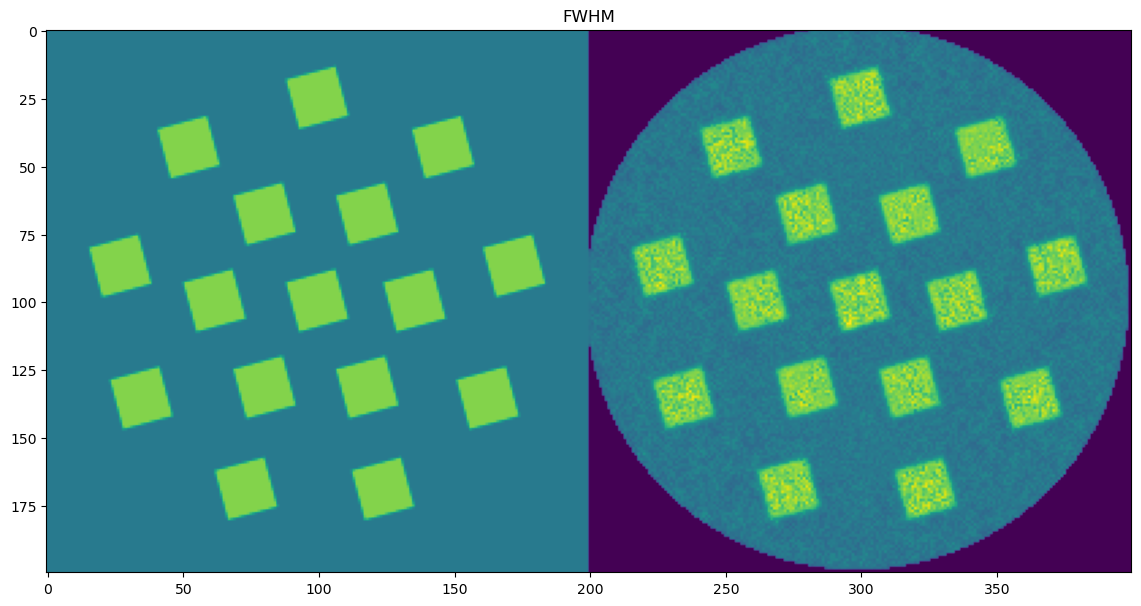

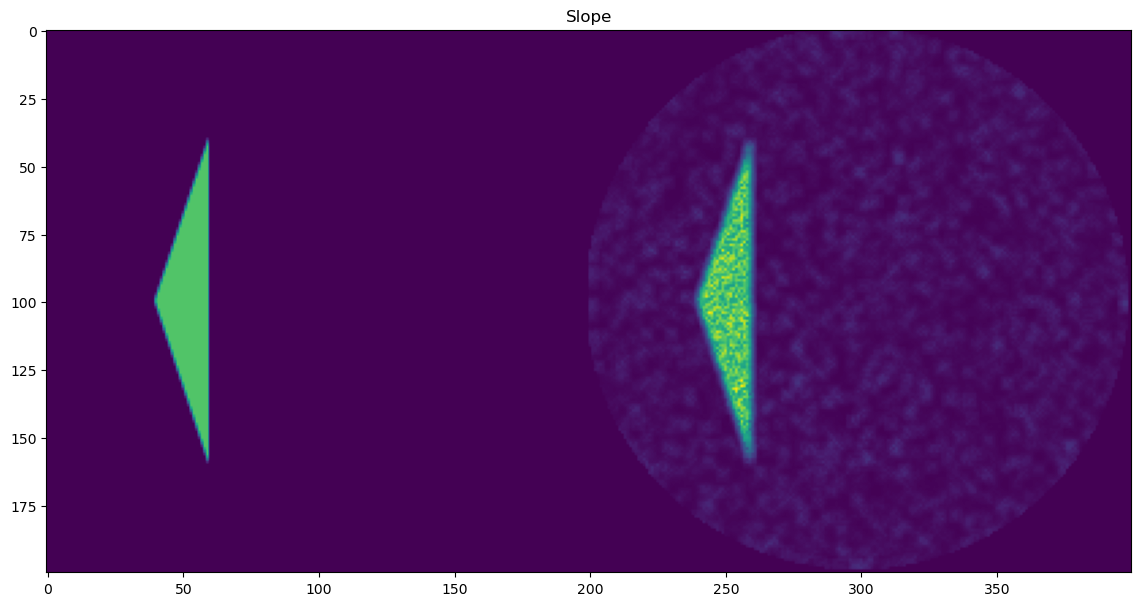

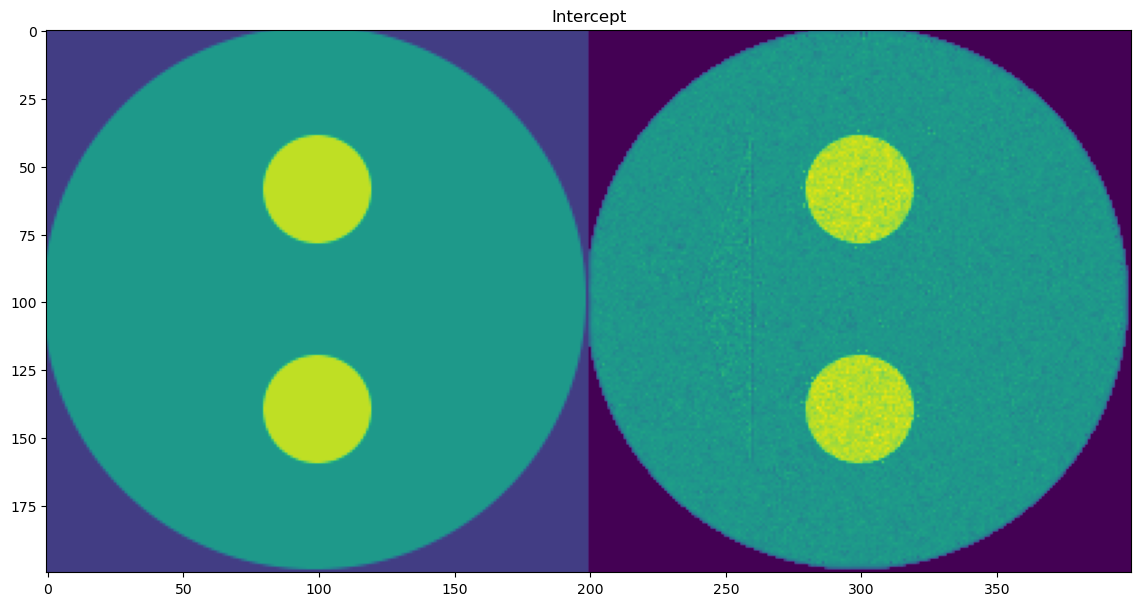

In [7]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('prms_only')
plt.show()

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

print(peak_area.shape, peak_position.shape, peak_fwhm.shape, peak_slope.shape, peak_intercept.shape)


ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

print(prms_peak1_area.shape, prms_peak1_pos.shape, prms_peak1_fwhm.shape, prms_slope.shape, prms_intercept.shape)

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac)
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc)
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc)
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec)
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc)
# plt.colorbar()
plt.title('Intercept')
plt.show()



## 🧠 Define and Prepare PeakFitCNN for Self-Supervised Training from Downsampled Input

We now instantiate the **PeakFitCNN model** that performs self-supervised peak fitting directly from **4× downsampled hyperspectral data**. This model is designed to replace the parameter map initialization used earlier with a CNN that learns the full-resolution parameter maps from a coarse input.

### 🏗️ Model Configuration

- `nch_in`: Number of input spectral channels (i.e., length of diffraction axis)
- `nch_out`: Number of predicted parameter maps (total of 5)
- `nfilts`: Number of filters in each layer; here set to match the number of input channels
- `upscale_factor`: 4× spatial upsampling to recover full-resolution output
- `norm_type`: Instance normalization for stability
- `activation`: Sigmoid activation ensures output values are bounded in [0, 1]

The total number of trainable parameters in the CNN is printed and compared against the number of parameters used in the **conventional approach**, which stores a separate value per parameter per voxel.

### 🔄 Prepare Inputs for CNN

We convert the original noisy 3D hyperspectral volume (`volp`) into a 4D tensor and **spatially downsample it** by a factor of 4 using bilinear interpolation. This downsampled input will be fed to the CNN to predict the full-resolution parameter maps.

This approach allows the model to:
- Exploit spatial context via convolution
- Combine denoising, peak fitting, and resolution enhancement in a single learned model

The shapes of both full-resolution and downsampled tensors are printed for verification.

In [8]:

model_cnn = PeakFitCNN(nch_in=volp.shape[2], nch_out=nch_out, nfilts=64,  upscale_factor = 4, norm_type='instance', 
              activation='Sigmoid', padding='same').to(device)
nch_in = volp.shape[2]
nfilts = volp.shape[2] # 2*total_params

# Calculate the total number of parameters
model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")

print('Number of filters:', nfilts)
print(nch_out, npix)

print("Conventional number of parameters:", npix*npix*total_params)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)
downsampled = F.interpolate(yobs, scale_factor=1/4, mode='bilinear', align_corners=False)

print(downsampled.shape, yobs.shape, yobs.shape[2]/4)

Total number of parameters: 105861
Number of filters: 50
5 304
Conventional number of parameters: 462080
torch.Size([1, 50, 76, 76]) torch.Size([1, 50, 304, 304]) 76.0


## 🔁 Train PeakFitCNN from Downsampled Hyperspectral Input

We now train the **PeakFitCNN model** using the 4× downsampled hyperspectral input volume. This deep-learning approach replaces explicit parameter map initialization with a CNN trained end-to-end to predict all peak parameters.

The training follows the same **self-supervised spectral reconstruction strategy** as before, but now the input is downsampled data and the model itself performs both super-resolution and peak fitting.

### ⚙️ Training Configuration

- `epochs = 50000`: maximum number of training epochs
- `prf = 0.2`: ±20% soft constraint around local average predictions to stabilize training
- `patience = 200`: used by the learning rate scheduler to detect plateaus
- `optimizer`: Adam with an initial learning rate of `0.001`
- `scheduler`: learning rate is halved on plateaus, down to a minimum of `1e-5`
- `num_patches`: number of spatial patches processed per batch

### 🧠 Training Loop

For each epoch:
1. A forward pass is performed using the downsampled hyperspectral data as input.
2. The CNN predicts full-resolution normalized parameter maps (`yc`).
3. A local average filter is applied, and values are **clamped within ±20%** of the smoothed estimates.
4. Spectral reconstruction is done using the same Gaussian + linear background model.
5. Random patches of the predicted and ground truth spectra are extracted.
6. The **RMSE loss** is computed between predicted and true spectra, and used for backpropagation.

The loop continues until convergence or the minimum learning rate is reached.

### 📈 Output

At the end of training, the code logs:
- Final **epoch count**
- Final **MAE, MSE, RMSE**
- Total **training time** in seconds
- A full log of the RMSE loss at each epoch (`logloss`), which can later be plotted to assess convergence

This completes the training of the second fitting approach, where **PeakFitCNN directly learns to denoise and fit peak parameters from low-resolution hyperspectral input**.

In [9]:

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

prf = 0.2
epochs = 50000
patience = 200
learning_rate = 0.001
min_lr = 1E-5
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model_cnn(downsampled)

        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
        lower_bound = filtered * (1.0 - prf)
        upper_bound = filtered * (1.0 + prf)
        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False) 
        
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

4


  0%|          | 3/50000 [00:03<12:57:17,  1.07it/s]

MAE =  tensor(0.1732, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0660, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2569, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.4005378


  0%|          | 103/50000 [00:09<50:33, 16.45it/s] 

MAE =  tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0036, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0604, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.054870572


  0%|          | 203/50000 [00:15<51:08, 16.23it/s]

MAE =  tensor(0.0335, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0030, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0548, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.049477812


  1%|          | 303/50000 [00:21<50:19, 16.46it/s]

MAE =  tensor(0.0323, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0026, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0507, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.046447042


  1%|          | 403/50000 [00:27<49:49, 16.59it/s]

MAE =  tensor(0.0321, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0026, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0505, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.044884283


  1%|          | 503/50000 [00:34<51:15, 16.09it/s]

MAE =  tensor(0.0313, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0476, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04243085


  1%|          | 603/50000 [00:40<48:21, 17.03it/s]

MAE =  tensor(0.0314, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0473, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.042047396


  1%|▏         | 703/50000 [00:46<50:49, 16.17it/s]

MAE =  tensor(0.0311, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0023, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0476, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04220297


  2%|▏         | 803/50000 [00:52<52:18, 15.68it/s]

MAE =  tensor(0.0306, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0457, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04059484


  2%|▏         | 903/50000 [00:58<50:41, 16.14it/s]

MAE =  tensor(0.0304, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0021, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0453, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.040293396


  2%|▏         | 1003/50000 [01:04<50:30, 16.17it/s]

MAE =  tensor(0.0301, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0446, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039884955


  2%|▏         | 1103/50000 [01:10<50:01, 16.29it/s]

MAE =  tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0451, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04002148


  2%|▏         | 1203/50000 [01:17<50:46, 16.02it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0440, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03918328


  3%|▎         | 1303/50000 [01:23<49:10, 16.50it/s]

MAE =  tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0442, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039144967


  3%|▎         | 1403/50000 [01:29<49:49, 16.26it/s]

MAE =  tensor(0.0302, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0447, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039464336


  3%|▎         | 1503/50000 [01:35<51:02, 15.83it/s]

MAE =  tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0020, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0447, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03941599


  3%|▎         | 1603/50000 [01:41<48:28, 16.64it/s]

MAE =  tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0435, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038623434


  3%|▎         | 1703/50000 [01:47<52:11, 15.42it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0427, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037803046


  4%|▎         | 1803/50000 [01:53<48:25, 16.59it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0434, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038453408


  4%|▍         | 1903/50000 [01:59<47:49, 16.76it/s]

MAE =  tensor(0.0297, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0432, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0383065


  4%|▍         | 2003/50000 [02:06<49:41, 16.10it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0430, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037970424


  4%|▍         | 2103/50000 [02:12<48:58, 16.30it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0429, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037824925


  4%|▍         | 2203/50000 [02:18<50:00, 15.93it/s]

MAE =  tensor(0.0290, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0423, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037494082


  5%|▍         | 2303/50000 [02:24<49:26, 16.08it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0430, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038061377


  5%|▍         | 2403/50000 [02:30<48:10, 16.47it/s]

MAE =  tensor(0.0295, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0019, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0434, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038341995


  5%|▌         | 2503/50000 [02:36<47:19, 16.73it/s]

MAE =  tensor(0.0291, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0423, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03757119


  5%|▌         | 2603/50000 [02:42<50:39, 15.60it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0418, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03698536


  5%|▌         | 2703/50000 [02:48<48:50, 16.14it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0417, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036908146


  6%|▌         | 2803/50000 [02:55<47:38, 16.51it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0417, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036866266


  6%|▌         | 2903/50000 [03:01<46:47, 16.78it/s]

MAE =  tensor(0.0289, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0421, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.037097044


  6%|▌         | 3003/50000 [03:07<48:44, 16.07it/s]

MAE =  tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0416, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036872633


  6%|▌         | 3103/50000 [03:13<47:46, 16.36it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0418, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03700842


  6%|▋         | 3203/50000 [03:19<47:53, 16.29it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0415, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036643803


  7%|▋         | 3303/50000 [03:25<48:28, 16.05it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0415, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036632564


  7%|▋         | 3403/50000 [03:32<48:18, 16.08it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036589064


  7%|▋         | 3503/50000 [03:38<50:34, 15.32it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0365892


  7%|▋         | 3603/50000 [03:44<48:28, 15.95it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036597125


  7%|▋         | 3703/50000 [03:50<46:18, 16.66it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0415, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03659235


  8%|▊         | 3803/50000 [03:56<47:46, 16.11it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03654419


  8%|▊         | 3903/50000 [04:03<47:11, 16.28it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03651854


  8%|▊         | 4003/50000 [04:09<46:15, 16.57it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03654952


  8%|▊         | 4103/50000 [04:15<46:22, 16.50it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03651145


  8%|▊         | 4203/50000 [04:21<48:06, 15.86it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036490053


  9%|▊         | 4303/50000 [04:27<49:13, 15.47it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0414, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03651625


  9%|▉         | 4403/50000 [04:33<46:05, 16.49it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0413, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036448818


  9%|▉         | 4503/50000 [04:39<45:33, 16.65it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0413, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036459617


  9%|▉         | 4603/50000 [04:45<47:37, 15.89it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0413, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036457766


  9%|▉         | 4703/50000 [04:52<45:31, 16.58it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0413, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03647318


 10%|▉         | 4803/50000 [04:58<47:46, 15.77it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03637666


 10%|▉         | 4903/50000 [05:04<45:35, 16.49it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036399033


 10%|█         | 5003/50000 [05:10<46:34, 16.10it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036345094


 10%|█         | 5103/50000 [05:16<47:53, 15.62it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036424443


 10%|█         | 5203/50000 [05:23<47:30, 15.71it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0412, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036337852


 11%|█         | 5303/50000 [05:29<46:02, 16.18it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03627412


 11%|█         | 5403/50000 [05:35<45:44, 16.25it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036271274


 11%|█         | 5503/50000 [05:41<45:36, 16.26it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036265247


 11%|█         | 5603/50000 [05:47<44:19, 16.69it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036304016


 11%|█▏        | 5703/50000 [05:53<45:48, 16.12it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0362691


 12%|█▏        | 5803/50000 [05:59<43:13, 17.04it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03625487


 12%|█▏        | 5903/50000 [06:05<45:21, 16.20it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036256954


 12%|█▏        | 6003/50000 [06:12<45:09, 16.24it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0411, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036235064


 12%|█▏        | 6103/50000 [06:18<46:50, 15.62it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036237806


 12%|█▏        | 6204/50000 [06:24<45:45, 15.95it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036219306


 13%|█▎        | 6304/50000 [06:30<44:13, 16.47it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036189184


 13%|█▎        | 6404/50000 [06:36<44:01, 16.50it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03618509


 13%|█▎        | 6504/50000 [06:42<45:15, 16.02it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036181226


 13%|█▎        | 6604/50000 [06:48<43:08, 16.77it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036176756


 13%|█▎        | 6704/50000 [06:55<44:32, 16.20it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036178336


 14%|█▎        | 6804/50000 [07:01<44:03, 16.34it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036174737


 14%|█▍        | 6904/50000 [07:07<43:45, 16.42it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036166575


 14%|█▍        | 7004/50000 [07:13<43:29, 16.48it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03615804


 14%|█▍        | 7104/50000 [07:19<42:48, 16.70it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0410, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03615785


 14%|█▍        | 7204/50000 [07:25<43:39, 16.34it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036146488


 15%|█▍        | 7304/50000 [07:31<43:55, 16.20it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036143623


 15%|█▍        | 7404/50000 [07:37<43:25, 16.35it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036137324


 15%|█▌        | 7504/50000 [07:43<43:48, 16.17it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036133833


 15%|█▌        | 7604/50000 [07:49<43:02, 16.42it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036127523


 15%|█▌        | 7704/50000 [07:55<43:06, 16.35it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036123827


 16%|█▌        | 7804/50000 [08:01<42:54, 16.39it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036129057


 16%|█▌        | 7904/50000 [08:08<43:24, 16.17it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036116444


 16%|█▌        | 8004/50000 [08:14<42:55, 16.31it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036117937


 16%|█▌        | 8104/50000 [08:20<42:29, 16.43it/s]

MAE =  tensor(0.0284, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036108773


 16%|█▋        | 8204/50000 [08:26<42:49, 16.27it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0361048


 17%|█▋        | 8304/50000 [08:32<42:26, 16.37it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036099356


 17%|█▋        | 8404/50000 [08:38<43:23, 15.98it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036095746


 17%|█▋        | 8504/50000 [08:44<42:47, 16.16it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03609185


 17%|█▋        | 8604/50000 [08:50<42:52, 16.09it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036084957


 17%|█▋        | 8704/50000 [08:56<42:02, 16.37it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03608349


 18%|█▊        | 8804/50000 [09:03<42:36, 16.12it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0409, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036082804


 18%|█▊        | 8904/50000 [09:09<41:29, 16.51it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03607136


 18%|█▊        | 9004/50000 [09:15<40:55, 16.69it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036073864


 18%|█▊        | 9104/50000 [09:21<41:38, 16.37it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036067106


 18%|█▊        | 9204/50000 [09:27<40:28, 16.80it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036062177


 19%|█▊        | 9304/50000 [09:33<41:12, 16.46it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036065638


 19%|█▉        | 9404/50000 [09:39<40:41, 16.63it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036060594


 19%|█▉        | 9504/50000 [09:45<41:35, 16.23it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036050767


 19%|█▉        | 9604/50000 [09:51<41:05, 16.38it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036053028


 19%|█▉        | 9704/50000 [09:57<41:30, 16.18it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036050394


 20%|█▉        | 9802/50000 [10:04<44:37, 15.01it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036040507


 20%|█▉        | 9904/50000 [10:10<44:16, 15.10it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036038123


 20%|██        | 10002/50000 [10:17<45:14, 14.74it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03603456


 20%|██        | 10102/50000 [10:24<46:04, 14.43it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036029324


 20%|██        | 10204/50000 [10:31<40:48, 16.25it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036036514


 21%|██        | 10304/50000 [10:37<39:59, 16.54it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036024313


 21%|██        | 10404/50000 [10:43<40:13, 16.41it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036035243


 21%|██        | 10504/50000 [10:49<40:14, 16.35it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036016315


 21%|██        | 10604/50000 [10:55<39:47, 16.50it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03601816


 21%|██▏       | 10704/50000 [11:01<40:25, 16.20it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036014397


 22%|██▏       | 10804/50000 [11:07<40:05, 16.30it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036009632


 22%|██▏       | 10904/50000 [11:13<39:40, 16.42it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.036011726


 22%|██▏       | 11004/50000 [11:19<39:22, 16.50it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0408, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035996597


 22%|██▏       | 11104/50000 [11:25<38:42, 16.75it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035994887


 22%|██▏       | 11204/50000 [11:31<39:43, 16.27it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035992566


 23%|██▎       | 11304/50000 [11:38<39:55, 16.15it/s]

MAE =  tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.035991404


 23%|██▎       | 11349/50000 [11:40<39:46, 16.19it/s]

Minimum learning rate reached, stopping the optimization
11349
11349 tensor(0.0283, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0407, device='cuda:0', grad_fn=<SqrtBackward0>) 0.035991013
700.8778886795044


## 🧪 Compare Parameter Maps from PeakFitCNN and Conventional Approach

After training the PeakFitCNN model on downsampled input, we now extract and visualize the predicted parameter maps. This section mirrors the post-processing used earlier for the conventional parameter maps, allowing for direct visual comparison.

### 📉 Loss Curve

We first plot the RMSE loss curve from the PeakFitCNN training (`logloss`), starting from epoch 100. This helps assess whether the model has converged and how its behavior compares to the conventional approach.

### 🗺️ Extract CNN-Predicted Parameters

We:
- Perform a forward pass through the trained PeakFitCNN using the downsampled input
- Apply local smoothing (`3×3` average pooling)
- Clamp predictions within ±20% of the smoothed values
- Denormalize all five parameter maps: area, position, FWHM, slope, and intercept

As before, we crop the output to remove padding (`ofs`) and apply a binary mask (`msk`) to focus only on relevant signal regions.

### 🔍 Side-by-Side Comparison

For each parameter, we concatenate the following maps side-by-side:
1. **Ground truth** from the simulation
2. **Conventional parameter map** (fit via `PrmCNN2D`)
3. **CNN prediction** (from PeakFitCNN)

These are visualized with `imshow()` using the `'jet'` colormap to highlight spatial gradients.

This comparison allows us to qualitatively assess:
- Fidelity to the true parameter maps
- Degree of denoising
- Spatial continuity and sharpness

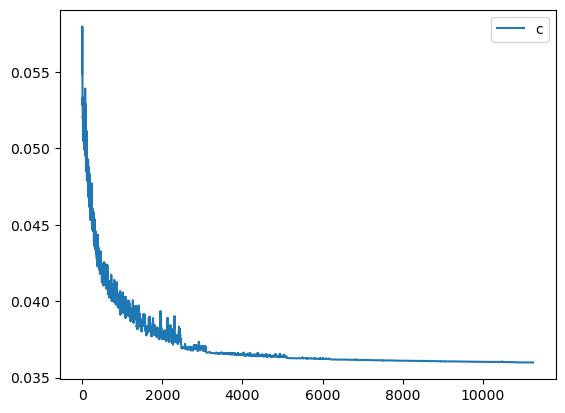

52
(200, 200) (200, 200) (200, 200)


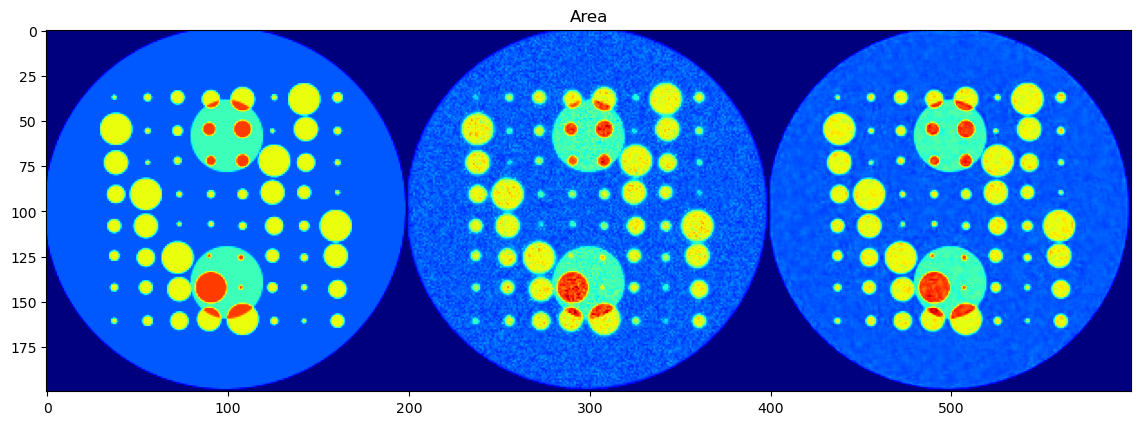

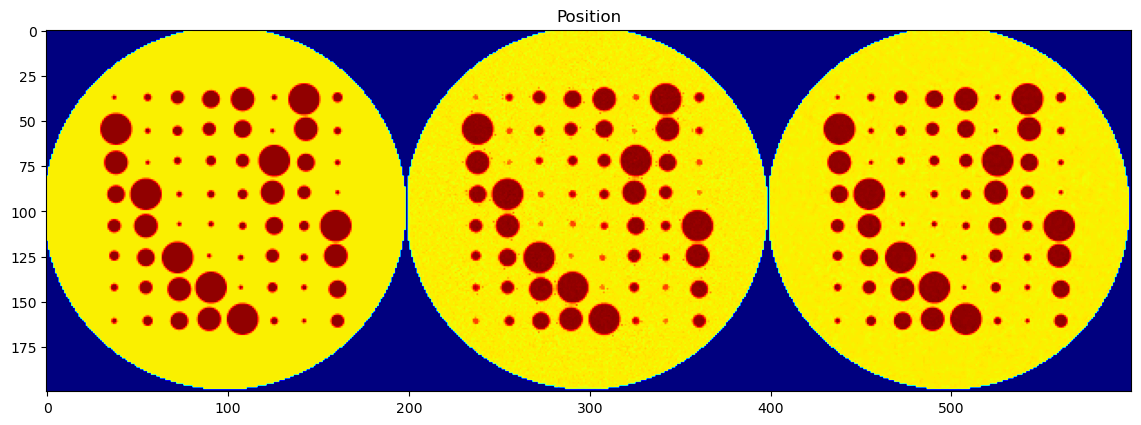

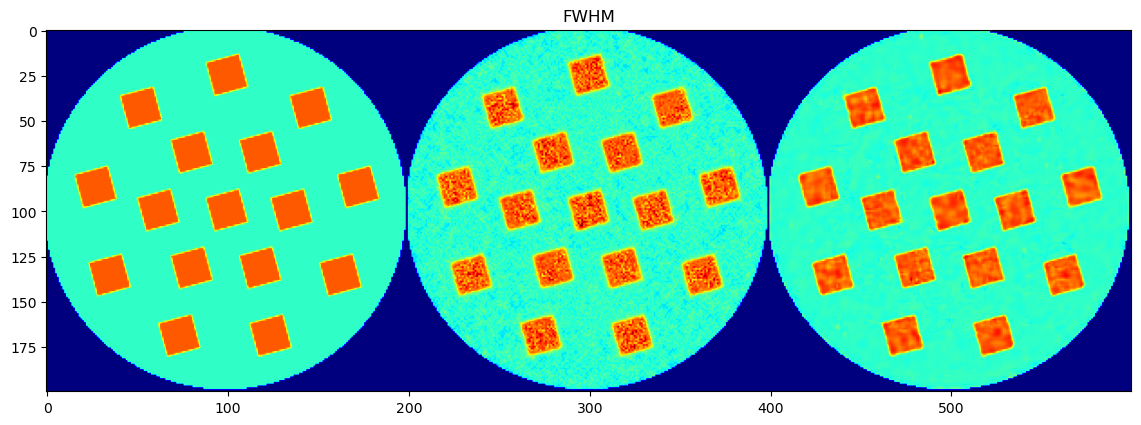

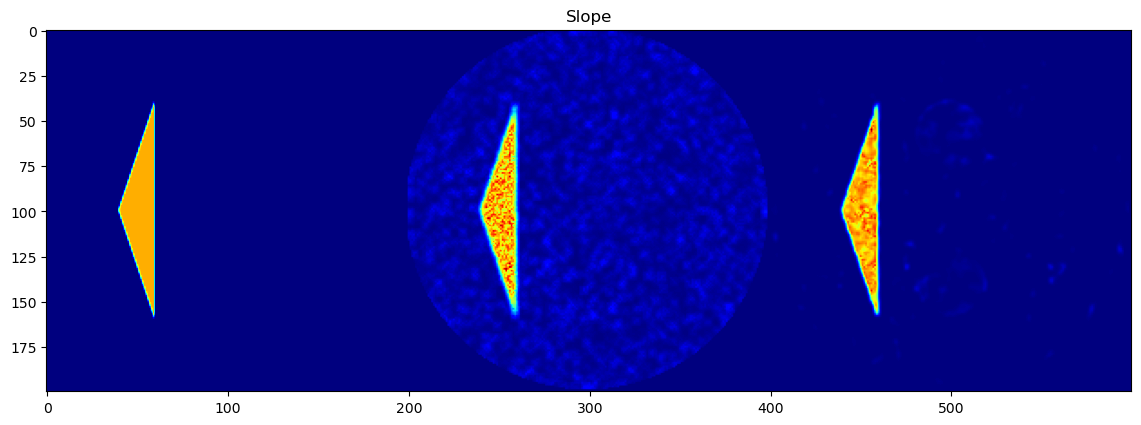

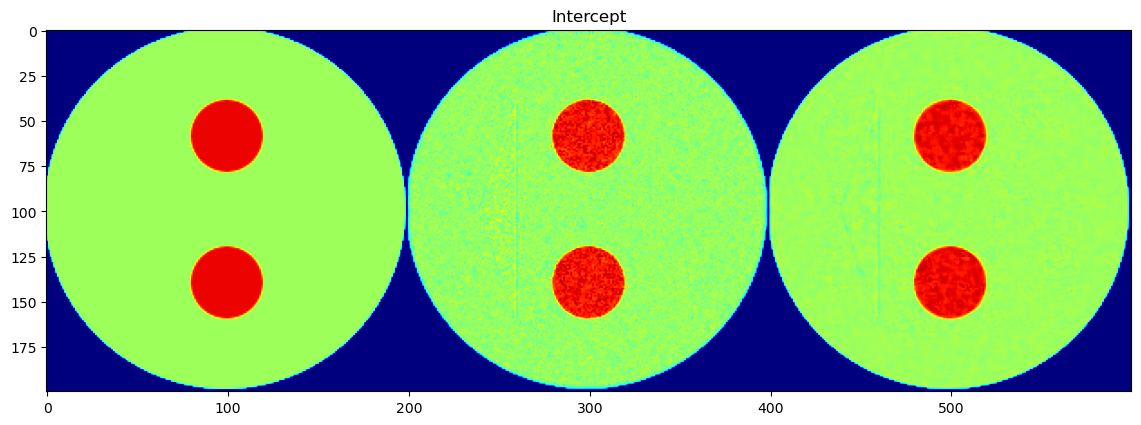

In [10]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.legend('cnn')
plt.show()

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)
print(ofs)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

print(peak_area.shape, prms_peak1_area.shape, cnn_peak1_area.shape)

areac = np.concatenate((peak_area*msk, prms_peak1_area*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, prms_peak1_pos*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, prms_peak1_fwhm*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, prms_slope*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, prms_intercept*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
plt.imshow(areac, cmap = 'jet')
# plt.colorbar()
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
plt.imshow(posc, cmap = 'jet')
# plt.colorbar()
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
plt.imshow(fwhmc, cmap = 'jet')
# plt.colorbar()
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
plt.imshow(slopec, cmap = 'jet')
# plt.colorbar()
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
plt.imshow(interceptc, cmap = 'jet')
# plt.colorbar()
plt.title('Intercept')
plt.show()


### 💾 Save Processed Parameter Maps to HDF5

To facilitate downstream analysis and reproducibility, we save all relevant parameter maps to an HDF5 file (`peak_fit_cnn_results.h5`). This includes:

- **Ground truth maps** (`*_gt`) from the synthetic simulation  
- **CNN predictions** (`*_cnn`) obtained from the trained `PeakFitCNN`  
- **Conventional estimates** (`*_prms`) from `PrmCNN2D`  
- **Side-by-side concatenated maps** (`*_concat`) used for visualization  

All maps are masked (`msk`) to include only signal-rich regions. The file is stored in the `examples/results/` directory of the `nDTomo` package using a relative path resolved by `ndtomopath()`.

This step ensures a compact, structured format for easy sharing, reproducibility, and integration with other analysis or visualization tools.

In [ ]:
import h5py, os
from nDTomo.methods.misc import ndtomopath

fn = os.path.join(ndtomopath(), 'examples', 'results', 'peak_fit_cnn_results.h5')

with h5py.File(fn, 'w') as f:

    f.create_dataset('peak_area_gt', data=peak_area*msk)
    f.create_dataset('peak_area_cnn', data=cnn_peak1_area*msk)
    f.create_dataset('peak_area_prms', data=prms_peak1_area*msk)

    f.create_dataset('peak_position_gt', data=peak_position*msk)
    f.create_dataset('peak_position_cnn', data=cnn_peak1_pos*msk)
    f.create_dataset('peak_position_prms', data=prms_peak1_pos*msk)

    f.create_dataset('peak_fwhm_gt', data=peak_fwhm*msk)
    f.create_dataset('peak_fwhm_cnn', data=cnn_peak1_fwhm*msk)
    f.create_dataset('peak_fwhm_prms', data=prms_peak1_fwhm*msk)

    f.create_dataset('peak_slope_gt', data=peak_slope*msk)
    f.create_dataset('peak_slope_cnn', data=cnn_slope*msk)
    f.create_dataset('peak_slope_prms', data=prms_slope*msk)

    f.create_dataset('peak_intercept_gt', data=peak_intercept*msk)
    f.create_dataset('peak_intercept_cnn', data=cnn_intercept*msk)
    f.create_dataset('peak_intercept_prms', data=prms_intercept*msk)

    f.create_dataset('peak_area_concat', data=areac)
    f.create_dataset('peak_position_concat', data=posc)
    f.create_dataset('peak_fwhm_concat', data=fwhmc)
    f.create_dataset('peak_slope_concat', data=slopec)  
    f.create_dataset('peak_intercept_concat', data=interceptc)



### 📏 Define Evaluation Metrics

To quantitatively compare the CNN-predicted and conventionally fitted parameter maps against the ground truth, we implement the following standard image quality metrics using NumPy and `scikit-image`:

- **MAE (Mean Absolute Error):**  
  Measures the average absolute difference between the predicted and ground truth values.

- **MSE (Mean Squared Error):**  
  Measures the average of the squared differences, penalizing larger errors more heavily.

- **RMSE (Root Mean Squared Error):**  
  The square root of MSE. While MSE penalizes larger errors more heavily due to squaring, RMSE transforms the result back to the original data scale, making it easier to interpret. It retains the sensitivity to large errors but is more directly comparable to the magnitude of the target values.

- **PSNR (Peak Signal-to-Noise Ratio):**  
  Indicates the ratio between the maximum possible signal and the noise introduced by prediction errors. Higher values imply better fidelity.

- **SSIM (Structural Similarity Index):**
  Evaluates perceived quality by comparing local patterns of pixel intensities. It accounts for luminance, contrast, and structural differences.


In [15]:
import numpy as np
from skimage.metrics import structural_similarity as ssim_skimage

def mae(gt, pred):
    return np.mean(np.abs(gt - pred))

def mse(gt, pred):
    return np.mean((gt - pred)**2)

def rmse(gt, pred):
    return np.sqrt(mse(gt, pred))

def psnr(gt, pred, data_range=None):
    if data_range is None:
        data_range = gt.max() - gt.min()
    return 20 * np.log10(data_range) - 10 * np.log10(mse(gt, pred))

def ssim(gt, pred, data_range=None):
    if data_range is None:
        data_range = gt.max() - gt.min()
    return ssim_skimage(gt, pred, data_range=data_range)


In [17]:
gt = peak_area * msk
cnn = cnn_peak1_area * msk
prms = prms_peak1_area * msk

print("CNN MAE:", mae(gt, cnn))
print("PRMS MAE:", mae(gt, prms))

print("CNN SSIM:", ssim(gt, cnn))
print("PRMS SSIM:", ssim(gt, prms))

print("CNN MSE:", mse(gt, cnn))
print("PRMS MSE:", mse(gt, prms))

print("CNN RMSE:", rmse(gt, cnn))
print("PRMS RMSE:", rmse(gt, prms))

print("CNN PSNR:", psnr(gt, cnn))
print("PRMS PSNR:", psnr(gt, prms))


CNN MAE: 0.013303014503925306
PRMS MAE: 0.029107784239922496
CNN SSIM: 0.9341961510281909
PRMS SSIM: 0.7535119632171398
CNN MSE: 0.000442023025410101
PRMS MSE: 0.0019397101105799962
CNN RMSE: 0.021024343638033054
PRMS RMSE: 0.0440421401680254
CNN PSNR: 35.48375133255038
PRMS PSNR: 29.06083196489327


In [18]:

gt = peak_position * msk
cnn = cnn_peak1_pos * msk
prms = prms_peak1_pos * msk
print("CNN MAE:", mae(gt, cnn))
print("PRMS MAE:", mae(gt, prms))

print("CNN SSIM:", ssim(gt, cnn))
print("PRMS SSIM:", ssim(gt, prms))

print("CNN MSE:", mse(gt, cnn))
print("PRMS MSE:", mse(gt, prms))

print("CNN RMSE:", rmse(gt, cnn))
print("PRMS RMSE:", rmse(gt, prms))

print("CNN PSNR:", psnr(gt, cnn))
print("PRMS PSNR:", psnr(gt, prms))


CNN MAE: 0.011272286995362351
PRMS MAE: 0.02075494284968317
CNN SSIM: 0.9842401451906617
PRMS SSIM: 0.9456191818793898
CNN MSE: 0.0002793819450679472
PRMS MSE: 0.0014905162023235471
CNN RMSE: 0.01671472240475286
PRMS RMSE: 0.038607204021057356
CNN PSNR: 45.080441728391214
PRMS PSNR: 37.80905808143828


In [ ]:
gt = peak_fwhm * msk
cnn = cnn_peak1_fwhm * msk
prms = prms_peak1_fwhm * msk
print("CNN MAE:", mae(gt, cnn))
print("PRMS MAE:", mae(gt, prms))
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS SSIM:", ssim(gt, prms))
print("CNN MSE:", mse(gt, cnn))
print("PRMS MSE:", mse(gt, prms))
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS RMSE:", rmse(gt, prms))
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS PSNR:", psnr(gt, prms))


CNN MAE: 0.005215739103140839
PRMS MAE: 0.012856494132103742
CNN SSIM: 0.8940192354609481
PRMS SSIM: 0.6301384426455998
CNN MSE: 7.973654680178997e-05
PRMS MSE: 0.00034600979917766923
CNN RMSE: 0.008929532283484391
PRMS RMSE: 0.01860133863940091
CNN PSNR: 33.02462559172557
PRMS PSNR: 26.650315842431304


In [20]:
gt = peak_slope * msk
cnn = cnn_slope * msk
prms = prms_slope * msk
print("CNN MAE:", mae(gt, cnn))
print("PRMS MAE:", mae(gt, prms))
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS SSIM:", ssim(gt, prms))
print("CNN MSE:", mse(gt, cnn))
print("PRMS MSE:", mse(gt, prms))
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS RMSE:", rmse(gt, prms))
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS PSNR:", psnr(gt, prms))

CNN MAE: 0.0001345843509497923
PRMS MAE: 0.001080107722561497
CNN SSIM: 0.9187152857005274
PRMS SSIM: 0.21302157235426353
CNN MSE: 4.617679578302625e-07
PRMS MSE: 2.4656262796886995e-06
CNN RMSE: 0.000679535104192758
PRMS RMSE: 0.0015702312822284173
CNN PSNR: 31.314562234972236
PRMS PSNR: 24.03952767050619


In [21]:
gt = peak_intercept * msk
cnn = cnn_intercept * msk
prms = prms_intercept * msk
print("CNN MAE:", mae(gt, cnn))
print("PRMS MAE:", mae(gt, prms))
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS SSIM:", ssim(gt, prms))
print("CNN MSE:", mse(gt, cnn))
print("PRMS MSE:", mse(gt, prms))
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS RMSE:", rmse(gt, prms))
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS PSNR:", psnr(gt, prms))


CNN MAE: 0.0021699085613043497
PRMS MAE: 0.005437449641303149
CNN SSIM: 0.8959402196654287
PRMS SSIM: 0.6510699621903274
CNN MSE: 1.321418373748907e-05
PRMS MSE: 6.711609884737454e-05
CNN RMSE: 0.003635131873466088
PRMS RMSE: 0.008192441568139168
CNN PSNR: 36.74839676153533
PRMS PSNR: 29.69053312346685


### ✅ Quantitative Comparison of CNN vs. Conventional Fitting

We evaluated the performance of the PeakFitCNN model against the conventional fitting approach using five standard metrics: **MAE**, **MSE**, **RMSE**, **SSIM**, and **PSNR**.

Across all parameter maps (area, position, FWHM, slope, and intercept), the CNN-based predictions consistently showed:

- **Lower MAE, MSE, and RMSE** compared to the conventional approach, indicating smaller average and squared errors.
- **Higher SSIM and PSNR**, suggesting better structural fidelity and improved signal-to-noise characteristics.

These results confirm that the PeakFitCNN model produces more accurate and visually coherent parameter maps than the conventional fitting method.

## Summary and Final Remarks

In this notebook, we compared two distinct strategies for hyperspectral peak fitting in synthetic XRD-CT datasets:

### 📌 Conventional Approach
- Uses explicit, per-parameter 2D maps to define each peak and background component.
- These parameter maps are trained directly to minimize spectral reconstruction error.
- While effective, this approach does not leverage spatial or spectral context beyond local filtering.

### 📌 PeakFitCNN (Self-Supervised CNN)
- Uses a downsampled hyperspectral input and learns to output **full-resolution, denoised parameter maps**.
- Trained using a **self-supervised loss** based on spectral reconstruction, requiring no labelled parameter maps.
- Combines denoising, resolution enhancement, and peak decomposition in a single, end-to-end architecture.

### 🧪 Results and Observations
- **Both methods successfully reconstructed the peak parameters**, even in the presence of Poisson noise.
- **PeakFitCNN showed improved spatial coherence**, and slightly lower noise levels in the parameter maps.
- The CNN was also able to generalize from lower-resolution inputs, demonstrating its potential for **super-resolution peak fitting** in real experimental contexts.

### 📈 Future Directions
- Extend to **multi-peak** or **asymmetric peak** fitting models (e.g. Pseudo-Voigt).
- Train PeakFitCNN on **experimental data** using self-supervised or semi-supervised frameworks.
- Integrate physical priors or constraints (e.g. non-negativity, continuity) directly into the CNN architecture.


This approach demonstrates the feasibility of combining physical modelling with modern deep learning techniques to enhance chemical imaging workflows in XRD-CT and beyond.